In [1]:
import psycopg2

from sqlalchemy import create_engine
from sqlalchemy import text

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn

%matplotlib inline

In [2]:
database_host='localhost'

In [3]:
def get_connection(host = "localhost",schema="" ):
    
    conn = psycopg2.connect("dbname='proj001_lfb' user='postgres' "
                            "host=" + host )
    if schema:
        cur = conn.cursor()
        query = "SET search_path TO {}".format(schema)
        cur.execute(query)

    return conn

# Create a feature dataset

## Incidents

In [4]:
conn = get_connection(host=database_host)
qry = ("select incidents.*, types.incidentgroup, types.stopcodedescription "
          "from proj001_lfb_1_0_0.l3_incidents incidents "
           "left join "
           "proj001_lfb_1_0_0.l3_incident_types types "
           "on "
           "incidents.id_incident_type = types.id"
          ";")
#data = pd.read_sql(qry, conn).drop(['store_no','store_type'], axis=1)  
df_incidents = pd.read_sql(qry, conn)  
conn.close()

# drop some columns that won't be features
df_incidents.drop(['num_stations_with_pumps_attending', 'num_pumps_attending'], axis =1 ,inplace=True)
df_incidents.head()

,id,incidentnumber_cln,dateofcall_cln,id_incident_type,id_property,id_postcode,incident_station_ground,incidentgroup,stopcodedescription
0,1,79398141,2014-06-22 10:21:15,2,24,108386,OVERTHEBORDER,False Alarm,False alarm - Good intent
1,2,168174131,2013-12-07 04:29:07,6,24,108387,OVERTHEBORDER,Fire,Primary Fire
2,3,168954111,2011-10-16 12:20:54,1,32,108388,BROMLEY,False Alarm,AFA
3,4,168866-17122017,2017-12-17 13:06:19,1,29,108388,BROMLEY,False Alarm,AFA
4,5,167600111,2011-10-14 11:58:03,1,24,108388,BROMLEY,False Alarm,AFA


## Postcodes

In [5]:
conn = get_connection(host=database_host)
qry = ('select *'
          'from proj001_lfb_1_0_0.l3_postcodes '
          ';')
#data = pd.read_sql(qry, conn).drop(['store_no','store_type'], axis=1)  
df_postcodes = pd.read_sql(qry, conn)  
conn.close()
print(df_postcodes.head())


   id postcode_full postcode_district incgeo_boroughname incgeo_wardname  \
0   1       AL1 3EA               AL1      NOT GEO-CODED   NOT GEO-CODED   
1   2       AL2 1QY               AL2      NOT GEO-CODED   NOT GEO-CODED   
2   3       AL8 7QA               AL8      NOT GEO-CODED   NOT GEO-CODED   
3   4       BR1 1AB               BR1            BROMLEY    BROMLEY TOWN   
4   5       BR1 1AE               BR1            BROMLEY    BROMLEY TOWN   

  incgeo_wardnamenew            frs  
0      NOT GEO-CODED  OVERTHEBORDER  
1      NOT GEO-CODED  OVERTHEBORDER  
2      NOT GEO-CODED  OVERTHEBORDER  
3       BROMLEY TOWN         LONDON  
4       BROMLEY TOWN         LONDON  


Here we discover that fields may need to be stripped of trailing spaces in the pipeline code and that a proportion of the postcodes are unlabelled.

In [6]:
df_empty_pcodes = df_postcodes[df_postcodes['incgeo_boroughname']
             .map(lambda x: x.strip()) == 'NOT GEO-CODED'][['postcode_full','incgeo_boroughname']]['postcode_full'].unique()
print("Unlabeled postcodes: " + str(len(pd.DataFrame(df_empty_pcodes)) ))
print("Total postcodes: " + str(len(df_postcodes) ))

Unlabeled postcodes: 1669
Total postcodes: 110157


In [7]:
df_postcodes.head(5)

,id,postcode_full,postcode_district,incgeo_boroughname,incgeo_wardname,incgeo_wardnamenew,frs
0,1,AL1 3EA,AL1,NOT GEO-CODED,NOT GEO-CODED,NOT GEO-CODED,OVERTHEBORDER
1,2,AL2 1QY,AL2,NOT GEO-CODED,NOT GEO-CODED,NOT GEO-CODED,OVERTHEBORDER
2,3,AL8 7QA,AL8,NOT GEO-CODED,NOT GEO-CODED,NOT GEO-CODED,OVERTHEBORDER
3,4,BR1 1AB,BR1,BROMLEY,BROMLEY TOWN,BROMLEY TOWN,LONDON
4,5,BR1 1AE,BR1,BROMLEY,BROMLEY TOWN,BROMLEY TOWN,LONDON


In [8]:
df_postcodes.drop(['incgeo_wardname','incgeo_wardnamenew'], inplace=True, axis =1 )

## Property details

In [9]:
conn = get_connection(host=database_host)
qry = ('select *'
          'from proj001_lfb_1_0_0.l3_property '
          ';')
#data = pd.read_sql(qry, conn).drop(['store_no','store_type'], axis=1)  
df_property = pd.read_sql(qry, conn)  
conn.close()
df_property.head(3)

,id,propertycategory,propertytype
0,1,Aircraft,Freight plane
1,2,Aircraft,Helicopter
2,3,Aircraft,Light aircraft


# Features dataset
Join together the relevant datasets and drop unnecessary columns.

In [10]:
df_features = pd.merge(pd.merge(df_incidents,df_postcodes,left_on='id_postcode',right_on='id', how='left') , 
                       df_property,left_on='id_property',right_on='id',how='left')
df_features.drop(['id','id_y'], inplace=True, axis =1)
df_features.head()

,id_x,incidentnumber_cln,dateofcall_cln,id_incident_type,id_property,id_postcode,incident_station_ground,incidentgroup,stopcodedescription,postcode_full,postcode_district,incgeo_boroughname,frs,propertycategory,propertytype
0,1,79398141,2014-06-22 10:21:15,2,24,108386,OVERTHEBORDER,False Alarm,False alarm - Good intent,None,AL7,NOT GEO-CODED,OVERTHEBORDER,Dwelling,House - single occupancy
1,2,168174131,2013-12-07 04:29:07,6,24,108387,OVERTHEBORDER,Fire,Primary Fire,None,AL8,NOT GEO-CODED,OVERTHEBORDER,Dwelling,House - single occupancy
2,3,168954111,2011-10-16 12:20:54,1,32,108388,BROMLEY,False Alarm,AFA,None,BR1,BROMLEY,LONDON,Dwelling,Self contained Sheltered Housing
3,4,168866-17122017,2017-12-17 13:06:19,1,29,108388,BROMLEY,False Alarm,AFA,None,BR1,BROMLEY,LONDON,Dwelling,Purpose Built Flats/Maisonettes - 4 to 9 storeys
4,5,167600111,2011-10-14 11:58:03,1,24,108388,BROMLEY,False Alarm,AFA,None,BR1,BROMLEY,LONDON,Dwelling,House - single occupancy


Reorder columns into tidydata format

In [11]:
df_features.columns.tolist
cols = ['id_x', 'dateofcall_cln','incidentnumber_cln', 'id_incident_type',
       'id_property', 'id_postcode', 'incident_station_ground',
     'postcode_full'
        ,'postcode_district'
       ,'incgeo_boroughname', 'frs', 'propertycategory', 'propertytype', 'incidentgroup','stopcodedescription']
df_features=df_features[cols]
df_features.head()

,id_x,dateofcall_cln,incidentnumber_cln,id_incident_type,id_property,id_postcode,incident_station_ground,postcode_full,postcode_district,incgeo_boroughname,frs,propertycategory,propertytype,incidentgroup,stopcodedescription
0,1,2014-06-22 10:21:15,79398141,2,24,108386,OVERTHEBORDER,None,AL7,NOT GEO-CODED,OVERTHEBORDER,Dwelling,House - single occupancy,False Alarm,False alarm - Good intent
1,2,2013-12-07 04:29:07,168174131,6,24,108387,OVERTHEBORDER,None,AL8,NOT GEO-CODED,OVERTHEBORDER,Dwelling,House - single occupancy,Fire,Primary Fire
2,3,2011-10-16 12:20:54,168954111,1,32,108388,BROMLEY,None,BR1,BROMLEY,LONDON,Dwelling,Self contained Sheltered Housing,False Alarm,AFA
3,4,2017-12-17 13:06:19,168866-17122017,1,29,108388,BROMLEY,None,BR1,BROMLEY,LONDON,Dwelling,Purpose Built Flats/Maisonettes - 4 to 9 storeys,False Alarm,AFA
4,5,2011-10-14 11:58:03,167600111,1,24,108388,BROMLEY,None,BR1,BROMLEY,LONDON,Dwelling,House - single occupancy,False Alarm,AFA


# Create the event label
First let's look at the different types of false alarms. AFA is an automatic alarm system. 

In [12]:
df_features[['incidentgroup','stopcodedescription']].drop_duplicates().sort_values(by='incidentgroup')

,incidentgroup,stopcodedescription
0,False Alarm,False alarm - Good intent
2,False Alarm,AFA
65,False Alarm,False alarm - Malicious
1,Fire,Primary Fire
14,Fire,Chimney Fire
571,Fire,Secondary Fire
3127,Fire,Late Call
452853,NULL,NULL
11,Special Service,Special Service
42,Special Service,Flood call attended - Batch mobilised


NULL alarm types are not significant so we will drop them

In [13]:
df_null_incidents=df_features.groupby(['incidentgroup','stopcodedescription']).count().reset_index()
print("Rows before drop: " + str(len(df_features)))
df_features=df_features.drop(df_features[df_features['incidentgroup'] == 'NULL'].index)
print("Rows after drop: " + str(len(df_features)))

Rows before drop: 993030
Rows after drop: 993027


Create the label variable to identify malicious false alarms. 

In [14]:
df_features['is_malicious_false_alarm'] = np.where(df_features['stopcodedescription'] == 'False alarm - Malicious', 1,0)
df_features[['incidentgroup','stopcodedescription','is_malicious_false_alarm']].drop_duplicates().sort_values(by='incidentgroup')


,incidentgroup,stopcodedescription,is_malicious_false_alarm
0,False Alarm,False alarm - Good intent,0
2,False Alarm,AFA,0
65,False Alarm,False alarm - Malicious,1
1,Fire,Primary Fire,0
14,Fire,Chimney Fire,0
571,Fire,Secondary Fire,0
3127,Fire,Late Call,0
11,Special Service,Special Service,0
42,Special Service,Flood call attended - Batch mobilised,0
36700,Special Service,Use of Special Operations Room,0


Look at whether this is an imbalanced class or not

In [15]:
# df_features.groupby(['is_malicious_false_alarm']).agg([ 'count'])
df_features.groupby(['is_malicious_false_alarm']).size()

is_malicious_false_alarm
0    977237
1     15790
dtype: int64

# Create derived variables

Create derived variables that may be useful predictors of malicious false alarms. 

In [16]:
df_features['incident_month']=df_features['dateofcall_cln'].dt.month
df_features['incident_week']=df_features['dateofcall_cln'].dt.week
df_features['incident_hour']=df_features['dateofcall_cln'].dt.hour
df_features['incident_day']=df_features['dateofcall_cln'].dt.dayofweek

def is_weekend(df):
    """Determine if a callout was at the weekend. By weekend we really mean from Friday evening onwards"""
    
    if df['incident_day'] == 6 or df['incident_day'] == 5:
        return 1
    elif df['incident_day'] == 4 and df['incident_hour']>=18:
        return 1 
    else:
        return 0
    
df_features['is_weekend'] = df_features.apply(is_weekend,axis =1)
print(df_features.dtypes)
df_features.head()

id_x                                 int64
dateofcall_cln              datetime64[ns]
incidentnumber_cln                  object
id_incident_type                     int64
id_property                          int64
id_postcode                          int64
incident_station_ground             object
postcode_full                       object
postcode_district                   object
incgeo_boroughname                  object
frs                                 object
propertycategory                    object
propertytype                        object
incidentgroup                       object
stopcodedescription                 object
is_malicious_false_alarm             int64
incident_month                       int64
incident_week                        int64
incident_hour                        int64
incident_day                         int64
is_weekend                           int64
dtype: object


,id_x,dateofcall_cln,incidentnumber_cln,id_incident_type,id_property,id_postcode,incident_station_ground,postcode_full,postcode_district,incgeo_boroughname,...,propertycategory,propertytype,incidentgroup,stopcodedescription,is_malicious_false_alarm,incident_month,incident_week,incident_hour,incident_day,is_weekend
0,1,2014-06-22 10:21:15,79398141,2,24,108386,OVERTHEBORDER,None,AL7,NOT GEO-CODED,...,Dwelling,House - single occupancy,False Alarm,False alarm - Good intent,0,6,25,10,6,1
1,2,2013-12-07 04:29:07,168174131,6,24,108387,OVERTHEBORDER,None,AL8,NOT GEO-CODED,...,Dwelling,House - single occupancy,Fire,Primary Fire,0,12,49,4,5,1
2,3,2011-10-16 12:20:54,168954111,1,32,108388,BROMLEY,None,BR1,BROMLEY,...,Dwelling,Self contained Sheltered Housing,False Alarm,AFA,0,10,41,12,6,1
3,4,2017-12-17 13:06:19,168866-17122017,1,29,108388,BROMLEY,None,BR1,BROMLEY,...,Dwelling,Purpose Built Flats/Maisonettes - 4 to 9 storeys,False Alarm,AFA,0,12,50,13,6,1
4,5,2011-10-14 11:58:03,167600111,1,24,108388,BROMLEY,None,BR1,BROMLEY,...,Dwelling,House - single occupancy,False Alarm,AFA,0,10,41,11,4,0


Weekends or particular times of night might be a good predictor of malicious false alarms.

In [16]:
df_events=df_features.groupby(['is_malicious_false_alarm','incident_day'])['is_malicious_false_alarm'].count()
print(df_events)


is_malicious_false_alarm  incident_day
0                         0               137478
                          1               138124
                          2               136820
                          3               139160
                          4               141587
                          5               146109
                          6               137959
1                         0                 2112
                          1                 2143
                          2                 2081
                          3                 2216
                          4                 2275
                          5                 2542
                          6                 2421
Name: is_malicious_false_alarm, dtype: int64


Here is a sample of when malicious false alarms happen. There seem to be more malicious calls on weekends than during the week.

65     0
105    0
141    3
212    0
247    1
Name: incident_day, dtype: int64


/app/software/anaconda3/envs/proj001_lfb/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


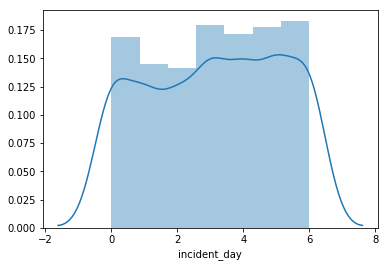

In [19]:
df_plot=df_features.loc[ df_features['is_malicious_false_alarm']==1 ]['incident_day']
print(df_plot.head())

chosen_idx = np.random.choice(len(df_plot), replace=False, size=1000)
df_plot = df_plot.iloc[chosen_idx]

sns.distplot(df_plot, hist=True, rug=False,bins=7);

0    6
1    5
2    6
3    6
4    4
Name: incident_day, dtype: int64


/app/software/anaconda3/envs/proj001_lfb/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


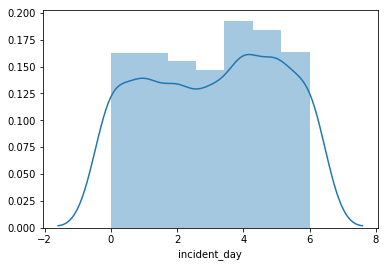

In [20]:
df_plot=df_features.loc[ df_features['is_malicious_false_alarm']==0 ]['incident_day']
print(df_plot.head())

chosen_idx = np.random.choice(len(df_plot), replace=False, size=1000)
df_plot = df_plot.iloc[chosen_idx]

sns.distplot(df_plot, hist=True, rug=False,bins=7);

# Is hour of day a good predictor?
It doesn't seem like hour of day is a good predictor

65      2
105    16
141    19
212    16
247     2
Name: incident_hour, dtype: int64


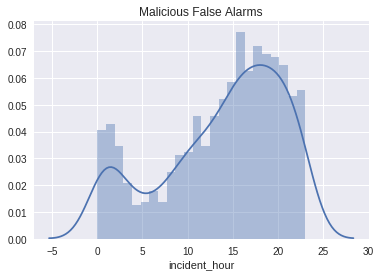

In [19]:
df_plot=df_features.loc[ df_features['is_malicious_false_alarm']==1 ]['incident_hour']
print(df_plot.head())

chosen_idx = np.random.choice(len(df_plot), replace=False, size=1000)
df_plot = df_plot.iloc[chosen_idx]

plt=sns.distplot(df_plot, bins=24,hist=True, rug=False);
plt.set_title('Malicious False Alarms')

0    10
1     4
2    12
3    13
4    11
Name: incident_hour, dtype: int64


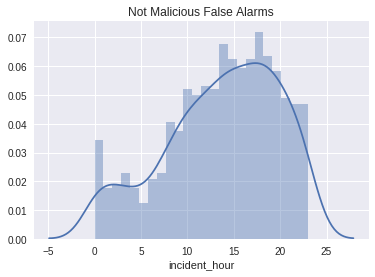

In [20]:
df_plot=df_features.loc[ df_features['is_malicious_false_alarm']==0 ]['incident_hour']
print(df_plot.head())

chosen_idx = np.random.choice(len(df_plot), replace=False, size=1000)
df_plot = df_plot.iloc[chosen_idx]

plt=sns.distplot(df_plot, bins=24,hist=True, rug=False);
plt.set_title('Not Malicious False Alarms')

# Save features dataset
This dataset was time consuming to create. We might like to pick up our work from here so let's save the dataset to the workproduct namespace. 
Note that the namespace for these datasets is the same as the workproduct ID and version number. 

In [17]:
import psycopg2
import sqlalchemy

database_host='localhost'
engine = create_engine('postgresql://postgres@'+database_host+':5432/proj001_lfb')

The following code may take several minutes depending on your database performance. 

In [18]:
print(len(df_features))

conn = engine.connect()
sql = text('drop schema if exists wp_005_false_alarm_analysis_01 cascade;')
conn.execute(sql)

sql = text('create schema if not exists wp_005_false_alarm_analysis_01;' )
conn.execute(sql)

df_features.to_sql(
    name='df_features'
    ,con= conn
    ,schema ='wp_005_false_alarm_analysis_01'
    ,if_exists = 'replace'
    ,index = False                 # do not write the dataframe index into a column
    ,chunksize = 50000             # process in chunks to avoid memory issues
)

conn.close()

993027


# Prepare data for algorithm

First retrieve the features dataset from our datastore

*Note:* something wrong when dataset is read back in. Algortihm fitting and tuning seems to fail

In [4]:
engine = create_engine('postgresql://postgres@'+database_host+':5432/proj001_lfb')


In [5]:
conn = engine.connect()
sql = "select * from wp_005_false_alarm_analysis_01.df_features;"

df_features = pd.read_sql(
    sql
    ,conn
    #,chunksize=50000
)

print(df_features.head())
#print(df_features.dtypes)
conn.close()

   id_x      dateofcall_cln incidentnumber_cln  id_incident_type  id_property  \
0     1 2014-06-22 10:21:15           79398141                 2           24   
1     2 2013-12-07 04:29:07          168174131                 6           24   
2     3 2011-10-16 12:20:54          168954111                 1           32   
3     4 2017-12-17 13:06:19    168866-17122017                 1           29   
4     5 2011-10-14 11:58:03          167600111                 1           24   

   id_postcode incident_station_ground postcode_full postcode_district  \
0       108386           OVERTHEBORDER          None               AL7   
1       108387           OVERTHEBORDER          None               AL8   
2       108388                 BROMLEY          None               BR1   
3       108388                 BROMLEY          None               BR1   
4       108388                 BROMLEY          None               BR1   

  incgeo_boroughname     ...     propertycategory  \
0      NOT GEO-

In [6]:
df_features.set_index('id_x',inplace=True)

In [7]:
print(len(df_features))
print(df_features.dtypes)
df_features.head(10)

993027
dateofcall_cln              datetime64[ns]
incidentnumber_cln                  object
id_incident_type                     int64
id_property                          int64
id_postcode                          int64
incident_station_ground             object
postcode_full                       object
postcode_district                   object
incgeo_boroughname                  object
frs                                 object
propertycategory                    object
propertytype                        object
incidentgroup                       object
stopcodedescription                 object
is_malicious_false_alarm             int64
incident_month                       int64
incident_week                        int64
incident_hour                        int64
incident_day                         int64
is_weekend                           int64
dtype: object


,dateofcall_cln,incidentnumber_cln,id_incident_type,id_property,id_postcode,incident_station_ground,postcode_full,postcode_district,incgeo_boroughname,frs,propertycategory,propertytype,incidentgroup,stopcodedescription,is_malicious_false_alarm,incident_month,incident_week,incident_hour,incident_day,is_weekend
id_x,,,,,,,,,,,,,,,,,,,,
1,2014-06-22 10:21:15,79398141,2,24,108386,OVERTHEBORDER,None,AL7,NOT GEO-CODED,OVERTHEBORDER,Dwelling,House - single occupancy,False Alarm,False alarm - Good intent,0,6,25,10,6,1
2,2013-12-07 04:29:07,168174131,6,24,108387,OVERTHEBORDER,None,AL8,NOT GEO-CODED,OVERTHEBORDER,Dwelling,House - single occupancy,Fire,Primary Fire,0,12,49,4,5,1
3,2011-10-16 12:20:54,168954111,1,32,108388,BROMLEY,None,BR1,BROMLEY,LONDON,Dwelling,Self contained Sheltered Housing,False Alarm,AFA,0,10,41,12,6,1
4,2017-12-17 13:06:19,168866-17122017,1,29,108388,BROMLEY,None,BR1,BROMLEY,LONDON,Dwelling,Purpose Built Flats/Maisonettes - 4 to 9 storeys,False Alarm,AFA,0,12,50,13,6,1
5,2011-10-14 11:58:03,167600111,1,24,108388,BROMLEY,None,BR1,BROMLEY,LONDON,Dwelling,House - single occupancy,False Alarm,AFA,0,10,41,11,4,0
6,2010-12-05 16:40:52,205145101,1,32,108388,BROMLEY,None,BR1,BROMLEY,LONDON,Dwelling,Self contained Sheltered Housing,False Alarm,AFA,0,12,48,16,6,1
7,2010-12-04 16:34:10,204529101,1,32,108388,BROMLEY,None,BR1,BROMLEY,LONDON,Dwelling,Self contained Sheltered Housing,False Alarm,AFA,0,12,48,16,5,1
8,2010-11-29 03:30:21,201106101,1,32,108388,BROMLEY,None,BR1,BROMLEY,LONDON,Dwelling,Self contained Sheltered Housing,False Alarm,AFA,0,11,48,3,0,0
9,2010-02-06 14:47:24,20245101,1,32,108388,BROMLEY,None,BR1,BROMLEY,LONDON,Dwelling,Self contained Sheltered Housing,False Alarm,AFA,0,2,5,14,5,1


Drop columns and rows we won't need

In [8]:
df_algorithm = df_features.drop(['incidentnumber_cln','incident_station_ground','id_postcode','postcode_full','frs','dateofcall_cln','id_incident_type','id_property'],axis =1)

# Drop the label variables
df_algorithm = df_algorithm.drop(['incidentgroup','stopcodedescription'],axis=1)

print(df_algorithm.head(5))

df_algorithm=df_algorithm.dropna()

     postcode_district incgeo_boroughname propertycategory  \
id_x                                                         
1                  AL7      NOT GEO-CODED         Dwelling   
2                  AL8      NOT GEO-CODED         Dwelling   
3                  BR1            BROMLEY         Dwelling   
4                  BR1            BROMLEY         Dwelling   
5                  BR1            BROMLEY         Dwelling   

                                           propertytype  \
id_x                                                      
1                             House - single occupancy    
2                             House - single occupancy    
3                     Self contained Sheltered Housing    
4     Purpose Built Flats/Maisonettes - 4 to 9 storeys    
5                             House - single occupancy    

      is_malicious_false_alarm  incident_month  incident_week  incident_hour  \
id_x                                                                   

## Prepare the training and test sets

### Encode all the categorical variables
### Property type

In [9]:

df_propertytype_one_hot = pd.get_dummies( df_algorithm['propertytype'])

# df_algorithm.drop('propertytype', inplace=True,axis=1)
df_algorithm=df_algorithm.join(df_propertytype_one_hot)

df_algorithm.head()

,postcode_district,incgeo_boroughname,propertycategory,propertytype,is_malicious_false_alarm,incident_month,incident_week,incident_hour,incident_day,is_weekend,...,Veterinary surgery,Warehouse,Wasteland,Water works,Wheelie bin (domestic size),Woodland/forest - broadleaf/hardwood,Woodland/forest - conifers/softwood,Young offenders unit,Youth hostel,Zoo
id_x,,,,,,,,,,,,,,,,,,,,,
1,AL7,NOT GEO-CODED,Dwelling,House - single occupancy,0,6,25,10,6,1,...,0,0,0,0,0,0,0,0,0,0
2,AL8,NOT GEO-CODED,Dwelling,House - single occupancy,0,12,49,4,5,1,...,0,0,0,0,0,0,0,0,0,0
3,BR1,BROMLEY,Dwelling,Self contained Sheltered Housing,0,10,41,12,6,1,...,0,0,0,0,0,0,0,0,0,0
4,BR1,BROMLEY,Dwelling,Purpose Built Flats/Maisonettes - 4 to 9 storeys,0,12,50,13,6,1,...,0,0,0,0,0,0,0,0,0,0
5,BR1,BROMLEY,Dwelling,House - single occupancy,0,10,41,11,4,0,...,0,0,0,0,0,0,0,0,0,0


### Property category

In [10]:

df_propertycategory_one_hot = pd.get_dummies( df_algorithm['propertycategory'], prefix= 'cat')
df_algorithm=df_algorithm.join(df_propertycategory_one_hot)
# df_algorithm.drop('propertycategory', inplace=True,axis=1)

In [11]:
df_algorithm.head()


,postcode_district,incgeo_boroughname,propertycategory,propertytype,is_malicious_false_alarm,incident_month,incident_week,incident_hour,incident_day,is_weekend,...,Zoo,cat_Aircraft,cat_Boat,cat_Dwelling,cat_Non Residential,cat_Other Residential,cat_Outdoor,cat_Outdoor Structure,cat_Rail Vehicle,cat_Road Vehicle
id_x,,,,,,,,,,,,,,,,,,,,,
1,AL7,NOT GEO-CODED,Dwelling,House - single occupancy,0,6,25,10,6,1,...,0,0,0,1,0,0,0,0,0,0
2,AL8,NOT GEO-CODED,Dwelling,House - single occupancy,0,12,49,4,5,1,...,0,0,0,1,0,0,0,0,0,0
3,BR1,BROMLEY,Dwelling,Self contained Sheltered Housing,0,10,41,12,6,1,...,0,0,0,1,0,0,0,0,0,0
4,BR1,BROMLEY,Dwelling,Purpose Built Flats/Maisonettes - 4 to 9 storeys,0,12,50,13,6,1,...,0,0,0,1,0,0,0,0,0,0
5,BR1,BROMLEY,Dwelling,House - single occupancy,0,10,41,11,4,0,...,0,0,0,1,0,0,0,0,0,0


### Borough name

In [12]:
df_borough_one_hot = pd.get_dummies( df_algorithm['incgeo_boroughname'], prefix= 'borough')

#df_algorithm.drop('incgeo_boroughname', inplace=True,axis=1)
df_algorithm=df_algorithm.join(df_borough_one_hot)

df_algorithm.head()

,postcode_district,incgeo_boroughname,propertycategory,propertytype,is_malicious_false_alarm,incident_month,incident_week,incident_hour,incident_day,is_weekend,...,borough_MERTON,borough_NEWHAM,borough_REDBRIDGE,borough_RICHMOND UPON THAMES,borough_SOUTHWARK,borough_SUTTON,borough_TOWER HAMLETS,borough_WALTHAM FOREST,borough_WANDSWORTH,borough_WESTMINSTER
id_x,,,,,,,,,,,,,,,,,,,,,
1,AL7,NOT GEO-CODED,Dwelling,House - single occupancy,0,6,25,10,6,1,...,0,0,0,0,0,0,0,0,0,0
2,AL8,NOT GEO-CODED,Dwelling,House - single occupancy,0,12,49,4,5,1,...,0,0,0,0,0,0,0,0,0,0
3,BR1,BROMLEY,Dwelling,Self contained Sheltered Housing,0,10,41,12,6,1,...,0,0,0,0,0,0,0,0,0,0
4,BR1,BROMLEY,Dwelling,Purpose Built Flats/Maisonettes - 4 to 9 storeys,0,12,50,13,6,1,...,0,0,0,0,0,0,0,0,0,0
5,BR1,BROMLEY,Dwelling,House - single occupancy,0,10,41,11,4,0,...,0,0,0,0,0,0,0,0,0,0


### Incident month, hour, day

In [13]:
# df_week_one_hot = pd.get_dummies( df_algorithm['incident_week'], prefix= 'week')
# df_algorithm=df_algorithm.join(df_week_one_hot)

df_day_one_hot = pd.get_dummies( df_algorithm['incident_day'], prefix= 'day')
df_algorithm=df_algorithm.join(df_day_one_hot)

df_hour_one_hot = pd.get_dummies( df_algorithm['incident_hour'], prefix= 'hour')
df_algorithm=df_algorithm.join(df_hour_one_hot)

df_month_one_hot = pd.get_dummies( df_algorithm['incident_month'], prefix= 'month')
df_algorithm=df_algorithm.join(df_month_one_hot)

df_algorithm.head()

,postcode_district,incgeo_boroughname,propertycategory,propertytype,is_malicious_false_alarm,incident_month,incident_week,incident_hour,incident_day,is_weekend,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
id_x,,,,,,,,,,,,,,,,,,,,,
1,AL7,NOT GEO-CODED,Dwelling,House - single occupancy,0,6,25,10,6,1,...,0,0,0,1,0,0,0,0,0,0
2,AL8,NOT GEO-CODED,Dwelling,House - single occupancy,0,12,49,4,5,1,...,0,0,0,0,0,0,0,0,0,1
3,BR1,BROMLEY,Dwelling,Self contained Sheltered Housing,0,10,41,12,6,1,...,0,0,0,0,0,0,0,1,0,0
4,BR1,BROMLEY,Dwelling,Purpose Built Flats/Maisonettes - 4 to 9 storeys,0,12,50,13,6,1,...,0,0,0,0,0,0,0,0,0,1
5,BR1,BROMLEY,Dwelling,House - single occupancy,0,10,41,11,4,0,...,0,0,0,0,0,0,0,1,0,0


### Clean up

In [15]:
df_algorithm.drop(['propertycategory','propertytype','postcode_district', 'incgeo_boroughname', 'incident_week', 'incident_hour', 'incident_day', 'incident_month'], inplace=True,axis=1)

print(df_algorithm.columns)

ValueError: labels ['propertycategory' 'propertytype' 'incgeo_boroughname' 'incident_week'
 'incident_hour' 'incident_day' 'incident_month'] not contained in axis

In [18]:
print(df_algorithm.columns)

Index(['is_malicious_false_alarm', 'is_weekend', 'Agricultural equipment ',
       'Agricultural vehicle', 'Airfield/runway ', 'Airport - fuel storage ',
       'Airport - hangar ', 'Airport - terminal ',
       'Airport building (not terminal or hangar) ', 'Ambulance station ',
       ...
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12'],
      dtype='object', length=379)


## Rebalance the class by downsampling the majority class

In [19]:
print(df_algorithm.groupby(['is_malicious_false_alarm']).size())

from sklearn.utils import resample
df_majority = df_algorithm[df_algorithm.is_malicious_false_alarm==0]
df_minority = df_algorithm[df_algorithm.is_malicious_false_alarm==1]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=15790,     # to match minority class
                                 random_state=123) # reproducible results

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

print(df_downsampled.groupby(['is_malicious_false_alarm']).size())


is_malicious_false_alarm
0    977237
1     15790
dtype: int64
is_malicious_false_alarm
0    15790
1    15790
dtype: int64


## Fit the model

In [20]:
X = df_downsampled.drop('is_malicious_false_alarm', axis=1)
y = df_downsampled['is_malicious_false_alarm']

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=101, shuffle=True)

/app/software/anaconda3/envs/proj001_lfb/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [22]:
print(X_train.head())
print("")
print(y_train.head())

        is_weekend  Agricultural equipment   Agricultural vehicle  \
id_x                                                                
966551           0                        0                     0   
165597           0                        0                     0   
467838           0                        0                     0   
698276           0                        0                     0   
430431           1                        0                     0   

        Airfield/runway   Airport - fuel storage   Airport - hangar   \
id_x                                                                   
966551                 0                        0                  0   
165597                 0                        0                  0   
467838                 0                        0                  0   
698276                 0                        0                  0   
430431                 0                        0                  0   

        Air

### Basic decision tree for comparison

In [23]:
from sklearn import tree


model_tree = tree.DecisionTreeClassifier()
model_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Random forest ensemble

In [24]:
print("Total number of features: " + str(len(df_algorithm.columns)))

Total number of features: 379


In [26]:
from sklearn.ensemble import RandomForestClassifier

# Train model
model_rf = RandomForestClassifier(n_estimators=500)
model_rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## Test the model

In [29]:
y_predict_tree = model_tree.predict(X_test)

y_predict_tree

array([1, 0, 0, ..., 1, 0, 1])

In [30]:
y_predict_rf = model_rf.predict(X_test)
y_predict_rf

array([1, 0, 0, ..., 0, 1, 0])

In [31]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_predict_tree))
print(accuracy_score(y_test,y_predict_rf))

0.5718809373020899
0.6272957568081063


Is the model always predicting the majority class and inflating accuracy?

In [32]:
df=pd.DataFrame(y_predict_rf , columns=['predictions'])
df.groupby('predictions')['predictions'].count()

predictions
0    3217
1    3099
Name: predictions, dtype: int64

In [33]:
from sklearn.metrics import confusion_matrix

pd.DataFrame(
    confusion_matrix(y_test, y_predict_tree),
    columns=['Predicted Not Malicious', 'Predicted Malicious'],
    index=['True Not Malicious', 'True Malicious']
)

,Predicted Not Malicious,Predicted Malicious
True Not Malicious,1785,1296
True Malicious,1408,1827


In [34]:
pd.DataFrame(
    confusion_matrix(y_test, y_predict_rf),
    columns=['Predicted Not Malicious', 'Predicted Malicious'],
    index=['True Not Malicious', 'True Malicious']
)

,Predicted Not Malicious,Predicted Malicious
True Not Malicious,1972,1109
True Malicious,1245,1990


### Extract feature importance from results

In [36]:
feature_list = list(X_test.columns)
feature_list

['is_weekend',
 'Agricultural equipment ',
 'Agricultural vehicle',
 'Airfield/runway ',
 'Airport - fuel storage ',
 'Airport - hangar ',
 'Airport - terminal ',
 'Airport building (not terminal or hangar) ',
 'Ambulance station ',
 'Animal boarding/breeding establishment - cats',
 'Animal boarding/breeding establishment - dogs',
 'Animal harm outdoors',
 'Animal products processing plant',
 'Art Gallery ',
 'Athletics Stadium ',
 'Bakery',
 'Bank/Building Society ',
 'Barbeque ',
 'Barge ',
 'Barn ',
 'Beach ',
 'Bicycle',
 'Bingo Hall ',
 'Boarding House/B&B for homeless/asylum seekers ',
 'Boarding House/B&B other ',
 'Boarding School accommodation ',
 'Boat - Tanker',
 'Bridge',
 'Bulk gas storage',
 'Bulk hazardous materials storage',
 'Bulk oil storage',
 'Bulk waste storage',
 'Bungalow - single occupancy ',
 'Bus/coach ',
 'Bus/coach station/garage ',
 'Cables ',
 'Call Centre ',
 'Camping tent ',
 'Canal/riverbank vegetation ',
 'Car ',
 'Caravan on tow ',
 'Caravan/Mobile ho

In [39]:
# Get numerical feature importances
importances = list(model_rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]
feature_importances

[('is_weekend', 0.0161),
 ('Agricultural equipment ', 0.0),
 ('Agricultural vehicle', 0.0),
 ('Airfield/runway ', 0.0),
 ('Airport - fuel storage ', 0.0),
 ('Airport - hangar ', 0.0001),
 ('Airport - terminal ', 0.0009),
 ('Airport building (not terminal or hangar) ', 0.0001),
 ('Ambulance station ', 0.0001),
 ('Animal boarding/breeding establishment - cats', 0.0),
 ('Animal boarding/breeding establishment - dogs', 0.0),
 ('Animal harm outdoors', 0.0001),
 ('Animal products processing plant', 0.0),
 ('Art Gallery ', 0.0001),
 ('Athletics Stadium ', 0.0001),
 ('Bakery', 0.0001),
 ('Bank/Building Society ', 0.0006),
 ('Barbeque ', 0.0004),
 ('Barge ', 0.0),
 ('Barn ', 0.0),
 ('Beach ', 0.0),
 ('Bicycle', 0.0001),
 ('Bingo Hall ', 0.0001),
 ('Boarding House/B&B for homeless/asylum seekers ', 0.0006),
 ('Boarding House/B&B other ', 0.0001),
 ('Boarding School accommodation ', 0.0),
 ('Boat - Tanker', 0.0),
 ('Bridge', 0.0003),
 ('Bulk gas storage', 0.0),
 ('Bulk hazardous materials storage

In [40]:

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: day_3                Importance: 0.0179
Variable: day_4                Importance: 0.0178
Variable: day_0                Importance: 0.0174
Variable: day_1                Importance: 0.0173
Variable: month_7              Importance: 0.0172
Variable: day_2                Importance: 0.0171
Variable: month_6              Importance: 0.0167
Variable: month_8              Importance: 0.0166
Variable: month_5              Importance: 0.0164
Variable: is_weekend           Importance: 0.0161
Variable: month_10             Importance: 0.0159
Variable: month_1              Importance: 0.0157
Variable: month_3              Importance: 0.0157
Variable: month_4              Importance: 0.0155
Variable: month_9              Importance: 0.0155
Variable: month_11             Importance: 0.0154
Variable: month_2              Importance: 0.0151
Variable: House - single occupancy  Importance: 0.0144
Variable: month_12             Importance: 0.0142
Variable: day_6                Importance: 0.